In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os,sys,inspect
import gc
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

In [4]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Input, Embedding, Flatten, Multiply
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test_job.csv')
sub = pd.read_csv('./data/sample_output_job.csv')
train

,userID,jobID,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1
3,f862b39f767d3a1991bdeb2ea1401c9c,3b5dca501ee1e6d8cd7b905f4e1bf723,0
4,cac14930c65d72c16efac2c51a6b7f71,287e03db1d99e0ec2edb90d079e142f3,0
...,...,...,...
5995,68cb94b97d00979f4e8127915885b641,b9228e0962a78b84f3d5d92f4faa000b,0
5996,c0b199d73bdf390c2f4c3150b6ee1574,e3796ae838835da0b6f6ea37bcf8bcb7,0
5997,3ab88dd28f749fe4ec90c0b6f9896eb5,e2a2dcc36a08a345332c751b2f2e476c,0
5998,75b4af0dacbc119eadf4eeb096738405,3b712de48137572f3849aabd5666a4e3,0


count    6000.000000
mean        0.142833
std         0.349932
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: applied, dtype: float64

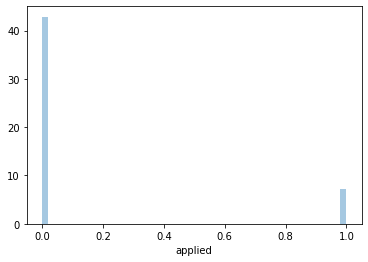

In [4]:
sns.distplot(train['applied'])
train['applied'].describe()

In [5]:
from sklearn.preprocessing import LabelEncoder

user_lbe = LabelEncoder()

user_lbe.fit(train['userID'])

LabelEncoder()

In [6]:
train['userID'] = user_lbe.transform(train['userID'])
test['userID'] = user_lbe.transform(test['userID'])

tag = pd.read_csv('./data/tags.csv')
tag_lbe = LabelEncoder()
tag['tagID'] = tag_lbe.fit_transform(tag['tagID'])

job_tag = pd.read_csv('./data/job_tags.csv')
job_lbe = LabelEncoder()

job_tag['jobID'] = job_lbe.fit_transform(job_tag['jobID'])
job_tag['tagID'] = tag_lbe.transform(job_tag['tagID'])
train['jobID'] = job_lbe.transform(train['jobID'])
test['jobID'] = job_lbe.transform(test['jobID'])

user_tag = pd.read_csv('./data/user_tags.csv')
user_tag['userID'] = user_lbe.transform(user_tag['userID'])
user_tag['tagID'] = tag_lbe.transform(user_tag['tagID'])

train

,userID,jobID,applied
0,195,52,0
1,64,245,0
2,111,35,1
3,190,177,0
4,159,117,0
...,...,...,...
5995,71,526,0
5996,154,650,0
5997,35,648,0
5998,83,178,0


In [7]:
def jaccard(true, pred):
    union = set(true).union(set(pred))
    inter = set(true).intersection(set(pred))
    return len(inter)/len(union)

In [8]:
jac = []
for i in range(len(train)):
    u = train.values[i][0]
    j = train.values[i][1]
    score = jaccard(np.unique(user_tag[user_tag['userID']==u].values), job_tag[job_tag['jobID']==j]['tagID'].values)
    jac.append(score)
    
train['jac'] = jac
train

,userID,jobID,applied,jac
0,195,52,0,0.000000
1,64,245,0,0.035714
2,111,35,1,0.100000
3,190,177,0,0.150000
4,159,117,0,0.041667
...,...,...,...,...
5995,71,526,0,0.066667
5996,154,650,0,0.103448
5997,35,648,0,0.080000
5998,83,178,0,0.090909


In [9]:
jac = []
for i in range(len(test)):
    u = test.values[i][0]
    j = test.values[i][1]
    score = jaccard(np.unique(user_tag[user_tag['userID']==u].values), job_tag[job_tag['jobID']==j]['tagID'].values)
    jac.append(score)
    
test['jac'] = jac
test

,userID,jobID,jac
0,180,157,0.166667
1,121,420,0.052632
2,29,252,0.076923
3,138,578,0.000000
4,166,213,0.000000
...,...,...,...
2430,3,110,0.000000
2431,116,540,0.250000
2432,162,351,0.100000
2433,116,448,0.111111


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
lr.fit(train['jac'].values.reshape(-1, 1), train['applied'].values.reshape(-1, 1))

LogisticRegression(class_weight='balanced')

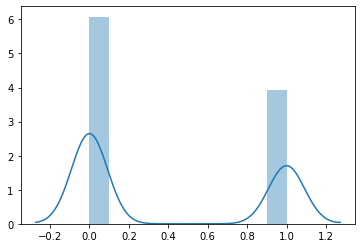

In [11]:
sns.distplot(lr.predict(train['jac'].values.reshape(-1, 1)))

In [12]:
np.sum(lr.predict(train['jac'].values.reshape(-1, 1)) == train['applied'].values) / len(lr.predict(train['jac'].values.reshape(-1, 1)) == train['applied'].values)

0.6121666666666666

In [13]:
from sklearn.model_selection import cross_val_score, cross_val_predict

cross_val_score(lr, train['jac'].values.reshape(-1, 1), train['applied'].values.reshape(-1, 1), cv=4)

array([0.63866667, 0.61466667, 0.60733333, 0.62      ])

In [14]:
lr.predict(test['jac'].values.reshape(-1, 1))

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

In [15]:
sub = pd.DataFrame(lr.predict(test['jac'].values.reshape(-1, 1)), columns=['applied'])
sub.to_csv('./sub/lr_jac.csv', index=False)

In [16]:
from tensorflow.keras.utils import to_categorical

uid = train['userID'].unique()
tid = job_tag['tagID'].unique()



In [17]:
j_tag =  []
for j in train['jobID'].values:
    arr = [0]*887
    tags = job_tag[job_tag['jobID']==j]['tagID'].values
    for t in tags:
        arr[t] = 1
    j_tag.append(arr)
j_tag = np.array(j_tag)
tr_ohe = np.hstack([to_categorical(train['userID'], len(uid)), j_tag])

In [18]:
j_tag =  []
for j in test['jobID'].values:
    arr = [0]*887
    tags = job_tag[job_tag['jobID']==j]['tagID'].values
    for t in tags:
        arr[t] = 1
    j_tag.append(arr)
j_tag = np.array(j_tag)
te_ohe = np.hstack([to_categorical(test['userID'], len(uid)), j_tag])

In [19]:
te_ohe.shape, tr_ohe.shape

((2435, 1083), (6000, 1083))

In [20]:
class FM_layer(keras.Model):
    def __init__(self, latent_dim, w_reg=1e-4, v_reg=1e-4):
        super(FM_layer, self).__init__()
        self.latent_dim = latent_dim
        
        self.w_reg = w_reg
        self.v_reg = v_reg

    def build(self, input_shape):
        self.w_0 = self.add_weight(shape=(1, ),
                                  initializer=tf.zeros_initializer(),
                                  trainable=True)
        
        self.w = self.add_weight(shape=(input_shape[-1], 1), 
                             initializer=tf.random_normal_initializer(),
                                trainable=True,
                                regularizer=l2(self.w_reg))
        
        self.V = self.add_weight(shape=(input_shape[-1], self.latent_dim), 
                             initializer=tf.random_normal_initializer(),
                                trainable=True,
                                regularizer=l2(self.v_reg))

    def call(self, inputs):
        linear_terms = tf.reduce_sum(tf.matmul(inputs, self.w), axis=1)

        interactions = 0.5 * tf.reduce_sum(
            tf.pow(tf.matmul(inputs, self.V), 2)
            - tf.matmul(tf.pow(inputs, 2), tf.pow(self.V, 2)),
            1,
            keepdims=False
        )

        y_hat = (self.w_0 + linear_terms + interactions)

        return y_hat

In [21]:
class DeepFM(tf.keras.Model):
    def __init__(self, x_dims, latent_dim, l2_emb=1e-4):
        super(DeepFM, self).__init__()
        
        self.x_dims = x_dims
        self.latent_dim = latent_dim

        self.embed_layers = {
            'embed_' + str(i): Embedding(input_dim=2,
                                         input_length=1,
                                         output_dim=latent_dim,
                                         embeddings_initializer='random_uniform',
                                         embeddings_regularizer=l2(l2_emb))
            for i, feat in enumerate(range(x_dims))
        }
        self.fm_layer = FM_layer(latent_dim)
        self.dnn_layers = self.build_dnn()
        self.flatten =  Flatten()
        self.linear = Dense(1)

    def build_dnn(self):
        model = Sequential()
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
        
        return model
        

    def call(self, inputs):        
        linear = self.linear(inputs)
        sparse_embed = tf.concat([self.embed_layers[f'embed_{i}'](inputs[:, i]) for i in range(self.x_dims)], axis=-1)

        fm_out = self.fm_layer(sparse_embed)

        deep_out = self.dnn_layers(sparse_embed)

        outputs = fm_out + tf.squeeze(deep_out) + linear
        
        return outputs

In [22]:
dfm = DeepFM(tr_ohe.shape[1], 32)

In [23]:
dfm.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
            optimizer=optimizers.Adam(2e-4))

dfm.fit(tr_ohe, 
       train['applied'].values,
      epochs=10,
      shuffle=True,
      validation_split=0.1,
       batch_size=128)

Epoch 1/10
43/43 [==============================] - 28s 655ms/step - loss: 0.7279 - val_loss: 0.7243
Epoch 2/10
43/43 [==============================] - 14s 334ms/step - loss: 0.6987 - val_loss: 0.7290
Epoch 3/10
43/43 [==============================] - 14s 333ms/step - loss: 0.6887 - val_loss: 0.7240
Epoch 4/10
43/43 [==============================] - 16s 376ms/step - loss: 0.6796 - val_loss: 0.7037
Epoch 5/10
43/43 [==============================] - 18s 409ms/step - loss: 0.6732 - val_loss: 0.7157
Epoch 6/10
43/43 [==============================] - 17s 397ms/step - loss: 0.6671 - val_loss: 0.6930
Epoch 7/10
43/43 [==============================] - 18s 430ms/step - loss: 0.6619 - val_loss: 0.6883
Epoch 8/10
43/43 [==============================] - 19s 444ms/step - loss: 0.6552 - val_loss: 0.6795
Epoch 9/10
43/43 [==============================] - 16s 369ms/step - loss: 0.6439 - val_loss: 0.6712
Epoch 10/10
43/43 [==============================] - 15s 354ms/step - loss: 0.6448 - val_lo

In [24]:
pred = dfm.predict(tr_ohe, batch_size=1024)
pred_ = np.where(pred>0, 1, 0)
sum(pred_==train['applied'].values) / len(pred_)

0.8571666666666666

In [25]:
pred = dfm.predict(te_ohe, batch_size=1024)
pred_ = np.where(pred>0, 1, 0)

sub = pd.DataFrame(pred_, columns=['applied'])
sub.to_csv('./sub/dfm_basic.csv', index=False)

In [26]:
class DeepFM_dense(tf.keras.Model):
    def __init__(self, sparse_dims, latent_dim, l2_emb=1e-4):
        super().__init__()
        
        self.sparse_dims = sparse_dims
        self.latent_dim = latent_dim

        self.embed_layers = {
            'embed_' + str(i): Embedding(input_dim=2, # ohe
                                         input_length=1,
                                         output_dim=latent_dim,
                                         embeddings_initializer='random_uniform',
                                         embeddings_regularizer=l2(l2_emb))
            for i, feat in enumerate(range(sparse_dims))
        }
        self.fm_layer = FM_layer(latent_dim)
        self.dnn_layers = self.build_dnn()
        self.flatten =  Flatten()
        self.linear = Dense(1)

    def build_dnn(self):
        model = Sequential()
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
        
        return model
        

    def call(self, inputs):        
        dense_inputs, sparse_inputs = inputs
        linear = self.linear(sparse_inputs)
        
        sparse_embed = tf.concat([self.embed_layers[f'embed_{i}'](sparse_inputs[:, i]) for i in range(self.sparse_dims)], axis=-1)
        stack = tf.concat([dense_inputs, sparse_embed], axis=-1)
        
        fm_out = self.fm_layer(stack)

        deep_out = self.dnn_layers(stack)

        outputs = fm_out + tf.squeeze(deep_out) + linear
        
        return outputs

In [27]:
tr_dense = train['jac'].values.reshape(-1, 1)
te_dense = test['jac'].values.reshape(-1, 1)

In [28]:
dfm_dense = DeepFM_dense(tr_ohe.shape[1], 32)

In [29]:
dfm_dense.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
            optimizer=optimizers.Adam(2e-4))

dfm_dense.fit([tr_dense, tr_ohe], 
       train['applied'].values,
      epochs=10,
      shuffle=True,
      validation_split=0.1)

Epoch 1/10
169/169 [==============================] - 69s 411ms/step - loss: 0.7124 - val_loss: 0.7104
Epoch 2/10
169/169 [==============================] - 57s 339ms/step - loss: 0.6846 - val_loss: 0.6992
Epoch 3/10
169/169 [==============================] - 59s 349ms/step - loss: 0.6712 - val_loss: 0.7084
Epoch 4/10
169/169 [==============================] - 59s 348ms/step - loss: 0.6573 - val_loss: 0.6664
Epoch 5/10
169/169 [==============================] - 58s 343ms/step - loss: 0.6466 - val_loss: 0.7046
Epoch 6/10
169/169 [==============================] - 57s 340ms/step - loss: 0.6266 - val_loss: 0.6441
Epoch 7/10
169/169 [==============================] - 58s 341ms/step - loss: 0.6180 - val_loss: 0.6417
Epoch 8/10
169/169 [==============================] - 58s 342ms/step - loss: 0.6080 - val_loss: 0.6282
Epoch 9/10
169/169 [==============================] - 58s 342ms/step - loss: 0.5942 - val_loss: 0.6287
Epoch 10/10
169/169 [==============================] - 59s 346ms/step - l

In [30]:
pred = dfm_dense.predict([tr_dense, tr_ohe], batch_size=1024)
pred_ = np.where(pred>0, 1, 0)
sum(pred_==train['applied'].values) / len(pred_)

0.8585

In [33]:
pred = dfm_dense.predict([te_dense, te_ohe], batch_size=1024)
pred_ = np.where(pred>0, 1, 0)

sub = pd.DataFrame(pred_, columns=['applied'])
sub.to_csv('./sub/dfm_d_basic.csv', index=False)